# Friends_text_analysis

![Friends](friends.jpg)

To analyse the American drama, Friends, I used some text analysis techniques. I downloaded the script from the Internet and started my analysis by organizing the script. In the ensuing sections, I'll be answer a few questions. 
1. What are the most frequently used words in the show?
2. How similar it is between two consecutive episodes?
3. What are the 10 most frequent words that connect to each charactor?
4. How strong are the connections among charactors?
5. What are the most frequently used words by each charactor?
6. How similar are each episode? Does it follow by seasons?

In this workbook, the following techniques will be used:
1. Web crawling
2. TF-iDF
3. Word2Vector
4. Doc2Vector
5. Principle component analysis (PCA)
6. Linear discriminant analysis (LDA)
7. t-SNE
8. K-means clustering
9. DBSCAN clustering

# Import Packages
-Importing the packages that I'll be using in this workbook

In [1]:
from bs4 import BeautifulSoup
import requests
from lxml import etree
import csv
import os
import pandas as pd

In [2]:
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
import collections

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
import word2vec
from numpy import dot
from numpy.linalg import norm
import numpy as np

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import manifold

In [6]:
from operator import add
import json
import networkx as nx  

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import cluster

# Web-crawling 
-Download the script from the Web

In [7]:
def get_html(url):
    try:
        user_agent = 'Mozilla/5.0'
        resp = requests.get(url, headers={'User-Agent': user_agent}, timeout = 30) #回傳為一個request.Response的物件
        resp.endcoding = 'utf8'
        return resp.text
    except:
        return 'ERROR'

In [8]:
def get_url_list():
    url_dict_list = []
    url_dict = {}
    url = 'https://fangj.github.io/friends/'
    resp_text = get_html(url)
    soup = BeautifulSoup(resp_text,"html.parser")
    sel = soup.select("body a")
    for i in sel:
        title_index = i.text.split(' ')
        title = str()
        for word in title_index[1:]:
            if len(word) != 0:
                title+=word
                title+=' '
        title = title[:-1]
        link = 'https://fangj.github.io/friends/' + i['href']
        attr = [title, link]
        url_dict[title_index[0]] = attr
    return url_dict

In [9]:
def get_script(url_dict):
    for i in list(url_dict.keys()):
        text = get_html(url_dict[i][1])
        html = etree.HTML(text)
        no_use_content = html.xpath('//p//text()')
        article = str()
        for j in no_use_content:
            wd = j.replace('\n',' ')
            wd = wd.replace('\r',' ')
            wd = wd.strip(' ')
            article += wd
            article += ' '
        if len(article)==0:
            no_use_content = html.xpath('//*/text()')
        for j in no_use_content:
            wd = j.replace('\n',' ')
            wd = wd.replace('\r',' ')
            wd = wd.strip(' ')
            article += wd
            article += ' '
        url_dict[i].append(article)
    return url_dict

# Write into csv file

In [10]:
def reshape_dict(new_url_dict):
    all_dict_list = []
    for i in new_url_dict.keys():
        new_dict = {}
        new_dict = {'Episode': i,'Title': new_url_dict[i][0],'Link': new_url_dict[i][1],'Script':new_url_dict[i][2] }
        all_dict_list.append(new_dict)
    return all_dict_list

In [11]:
def write_file(new_url_dict):
    all_dict_list = reshape_dict(new_url_dict)
    with open('Friends_data.csv', 'w', newline='') as csvfile:
        fieldnames = ['Episode', 'Title','Link','Script']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in all_dict_list:
            writer.writerow(i)
    print('Done!')

# Read from csv file

In [12]:
def read_file():
    with open('Friends_data.csv','r') as csvfile:
        reader = csv.DictReader(csvfile)
        dic = {}
        for row in reader:
            i = list(row.values())
            dic[i[0]] = [i[1],i[2],i[3]]
    return dic

In [142]:
df = pd.read_csv('Friends_data.csv') #read in data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
Episode    228 non-null object
Title      228 non-null object
Link       228 non-null object
Script     228 non-null object
dtypes: object(4)
memory usage: 7.2+ KB


,Episode,Title,Link,Script
0,101,Monica Gets A Roommate,https://fangj.github.io/friends/season/0101.html,Written by: Marta Kauffman & David Crane [Scen...
1,102,The Sonogram At The End,https://fangj.github.io/friends/season/0102.html,Written by: Marta Kauffman & David Crane [Scen...
2,103,The Thumb,https://fangj.github.io/friends/season/0103.html,Written by: Jeffrey Astrof & Mike Sikowitz. Tr...
3,104,George Stephanopoulos,https://fangj.github.io/friends/season/0104.html,Written by: Alexa Junge Transcribed by: guinea...
4,105,The East German Laundry Detergent,https://fangj.github.io/friends/season/0105.html,Written by: Jeff Greenstein & Jeff Strauss Tra...


In [358]:
#add season 
for i in range(211):
    df['Season'][i] = df['Episode'][i][0]
for i in range(211,228):
    df['Season'][i] = 10

# Q1: What are the most frequently used words in the show?

## Word Count

In [15]:
df['Word_count'] = df['Script'].apply(lambda x: len(str(x).split(" ")))
df.head()

,Episode,Title,Link,Script,Word_count
0,101,Monica Gets A Roommate,https://fangj.github.io/friends/season/0101.html,Written by: Marta Kauffman & David Crane [Scen...,8859
1,102,The Sonogram At The End,https://fangj.github.io/friends/season/0102.html,Written by: Marta Kauffman & David Crane [Scen...,6233
2,103,The Thumb,https://fangj.github.io/friends/season/0103.html,Written by: Jeffrey Astrof & Mike Sikowitz. Tr...,6473
3,104,George Stephanopoulos,https://fangj.github.io/friends/season/0104.html,Written by: Alexa Junge Transcribed by: guinea...,6811
4,105,The East German Laundry Detergent,https://fangj.github.io/friends/season/0105.html,Written by: Jeff Greenstein & Jeff Strauss Tra...,6783


In [16]:
df['Word_count'].describe()

count      228.000000
mean      7833.850877
std       1913.146817
min        719.000000
25%       6967.500000
50%       7432.000000
75%       8018.500000
max      17123.000000
Name: Word_count, dtype: float64

In [17]:
#listed out top 10 common words
common_words = pd.Series(' '.join(df.Script).split()).value_counts()[:10]
print(common_words)

I            47214
the          45570
to           35267
you          34791
and          32952
a            29412
is           16795
Rachel:      15875
Ross:        15083
Chandler:    14249
dtype: int64


## Clean up the data

In [193]:
stop_words = set(stopwords.words("english"))
add_words = ['marta','kauffman','david','crane','scene','aasen','c','oh','u','uh','ah','wanna','ju','em','ev','um','know','yeah','hey','okay','well','say','w','wh','h']
stop_words = stop_words.union(add_words)

In [194]:
all_text = []
for i in range(len(df)):
    text = re.sub('[^a-zA-Z]', ' ', df['Script'][i])
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text = text.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    all_text.append(text)

In [20]:
collections.Counter(' '.join(all_text).split(' '))

Counter({'written': 416,
         'central': 1226,
         'perk': 1198,
         'chandler': 25886,
         'joey': 25827,
         'phoebe': 21053,
         'monica': 25681,
         'nothing': 938,
         'tell': 2529,
         'guy': 5756,
         'work': 1412,
         'mon': 570,
         'going': 3046,
         'gotta': 996,
         'something': 2321,
         'wrong': 657,
         'right': 7166,
         'nice': 1139,
         'hump': 6,
         'hairpiece': 2,
         'wait': 2118,
         'eat': 422,
         'chalk': 12,
         'stare': 312,
         'bemused': 2,
         'cause': 957,
         'want': 4007,
         'go': 6987,
         'went': 705,
         'carl': 60,
         'everybody': 546,
         'relax': 183,
         'even': 1318,
         'date': 854,
         'two': 1707,
         'people': 1441,
         'dinner': 570,
         'sex': 612,
         'sound': 670,
         'like': 6928,
         'time': 3105,
         'lapse': 198,
         'alright

In [13]:
len(list(collections.Counter(' '.join(all_text).split(' '))))

15170

In [21]:
# Found out that the top 6 most common words are exactly the name of the main characters
list(collections.Counter(' '.join(all_text).split(' ')).most_common(100))

[('ross', 27503),
 ('rachel', 27228),
 ('chandler', 25886),
 ('joey', 25827),
 ('monica', 25681),
 ('phoebe', 21053),
 ('get', 7473),
 ('right', 7166),
 ('look', 7032),
 ('go', 6987),
 ('like', 6928),
 ('guy', 5756),
 ('gonna', 5752),
 ('really', 5228),
 ('one', 5122),
 ('think', 5037),
 ('see', 4821),
 ('mean', 4316),
 ('come', 4246),
 ('want', 4007),
 ('back', 4007),
 ('got', 3757),
 ('good', 3521),
 ('god', 3381),
 ('would', 3180),
 ('time', 3105),
 ('going', 3046),
 ('start', 3038),
 ('thing', 2939),
 ('sorry', 2895),
 ('hi', 2840),
 ('take', 2817),
 ('little', 2767),
 ('ok', 2741),
 ('let', 2717),
 ('great', 2684),
 ('mr', 2673),
 ('tell', 2529),
 ('make', 2520),
 ('yes', 2478),
 ('door', 2416),
 ('something', 2321),
 ('could', 2294),
 ('room', 2273),
 ('love', 2207),
 ('hand', 2163),
 ('wait', 2118),
 ('apartment', 1947),
 ('still', 1938),
 ('way', 1888),
 ('walk', 1880),
 ('maybe', 1838),
 ('give', 1789),
 ('umm', 1776),
 ('woman', 1775),
 ('man', 1741),
 ('said', 1735),
 ('phon

# A1: 
We can see from the list above. The top 6 most common words are exactly the name of the 6 main characters. As we look at other frequently used words, we can find that the show used a lot of simple words such as look, go, really, mean, come, good...etc, and I believe that is the reason why people who watched this show before always say that this show is a good start for people who want to learn English by watching American drama.

## Vectorize text

-Next, I vectorize the script to do some further analysis. I used text frequency(TF), TF-iDF and Word2Vector respectively. 

### TF

In [22]:
vectorizer = CountVectorizer(max_df=0.9,stop_words=stop_words, max_features=15000, ngram_range=(1,2))
text_vectorized = vectorizer.fit_transform(all_text)
vectorizer.get_feature_names()

['aaah',
 'aah',
 'aaron',
 'abandoned',
 'abbey',
 'ability',
 'able',
 'able get',
 'able make',
 'abrams',
 'abrams transcribed',
 'absolute',
 'absolutely',
 'absolutely joey',
 'accent',
 'accept',
 'access',
 'accident',
 'accidentally',
 'according',
 'account',
 'ace',
 'ache',
 'across',
 'across hall',
 'across room',
 'across street',
 'act',
 'act like',
 'acted',
 'acting',
 'acting class',
 'acting like',
 'action',
 'action joey',
 'action monica',
 'actor',
 'actress',
 'actress olivia',
 'actual',
 'actually came',
 'actually get',
 'actually getting',
 'actually going',
 'actually gonna',
 'actually good',
 'actually got',
 'actually joey',
 'actually kinda',
 'actually look',
 'actually monica',
 'actually one',
 'actually phoebe',
 'actually rachel',
 'actually really',
 'actually ross',
 'actually see',
 'actually think',
 'actually thought',
 'ad',
 'adam',
 'adam chase',
 'add',
 'added',
 'adding',
 'addition',
 'addition adjustment',
 'address',
 'adelman',
 'a

In [23]:
text_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [284]:
df.Title

0                 Monica Gets A Roommate
1                The Sonogram At The End
2                              The Thumb
3                  George Stephanopoulos
4      The East German Laundry Detergent
5                               The Butt
6                           The Blackout
7                        Nana Dies Twice
8                     Underdog Gets Away
9                             The Monkey
10                             Mrs. Bing
11                    The Dozen Lasagnas
12                           The Boobies
13                      The Candy Hearts
14                        The Stoned Guy
15                 The Two Parts, Part I
16                The Two Parts, Part II
17                         All The Poker
18                  The Monkey Gets Away
19                 The Evil Orthodontist
20                       The Fake Monica
21                        The Ick Factor
22                             The Birth
23                      Rachel Finds Out
24              

In [25]:
text_vectorized[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

# Q2: How similar it is between two consecutive episodes?

#### Find episodes similarity with TF

In [26]:
def cosine_similarity_tf(df,text_vec,doc1,doc2):
    doc1_num = pd.Index(list(df.Episode)).get_loc(str(doc1))
    doc2_num = pd.Index(list(df.Episode)).get_loc(str(doc2))
    a = text_vec[doc1_num].toarray()
    b = text_vec[doc2_num].toarray()
    return dot(a, b.T)/(norm(a)*norm(b))

In [27]:
cosine_similarity_tf(df,text_vectorized,1011,1012).tolist()[0][0]

0.23760629002570685

In [28]:
def next_ep_sim(df,text_vec):
    sim_list = []
    for i in range(227):
        sim_list.append(cosine_similarity_tf(df,text_vec,df.Episode[i],df.Episode[i+1]).tolist()[0][0])
    return sim_list

In [29]:
sim_list = next_ep_sim(df,text_vectorized)
episode_idx = list(map(add,[i for i in range(227)],[0.5]*227))

<function matplotlib.pyplot.show(*args, **kw)>

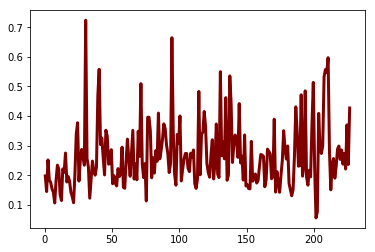

<Figure size 4320x4320 with 0 Axes>

In [30]:
#The following plot show the similarity between two consecutive episodes based on TF
plt.plot(episode_idx,sim_list, color='maroon', linewidth=3)
plt.figure(figsize=(60,60))
plt.show

### TF-iDF

In [31]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(all_text))

In [32]:
tfidf[2].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
print(tfidf[1])

  (0, 14978)	0.013336618554097167
  (0, 14972)	0.006593483030231635
  (0, 14970)	0.008603908051804372
  (0, 14960)	0.011753376951523353
  (0, 14902)	0.019149515614268763
  (0, 14889)	0.01736633685792929
  (0, 14887)	0.023572033252398084
  (0, 14883)	0.012071433091976265
  (0, 14874)	0.012115894782980067
  (0, 14858)	0.0051958453623355836
  (0, 14764)	0.01059167532134975
  (0, 14749)	0.007662717350055517
  (0, 14748)	0.015119797310436639
  (0, 14742)	0.013799979345250344
  (0, 14735)	0.018631522320050196
  (0, 14725)	0.015325434700111034
  (0, 14719)	0.02043112156147248
  (0, 14685)	0.015314084229619928
  (0, 14676)	0.00742706134052457
  (0, 14668)	0.008554214190404287
  (0, 14654)	0.011178927683811861
  (0, 14646)	0.008041714788144139
  (0, 14645)	0.015583158101589818
  (0, 14636)	0.08879151933091656
  (0, 14630)	0.0177223323517159
  :	:
  (0, 300)	0.0332861062323463
  (0, 276)	0.015165508114657559
  (0, 264)	0.008756450277803477
  (0, 256)	0.01059167532134975
  (0, 254)	0.017014320240

#### Find episodes similarity with TF-iDF

In [34]:
cosine_similarity_tf(df,tfidf,1010,102)

array([[0.06696681]])

In [35]:
sim_list = next_ep_sim(df,tfidf)
episode_idx = list(map(add,[i for i in range(227)],[0.5]*227))

<function matplotlib.pyplot.show(*args, **kw)>

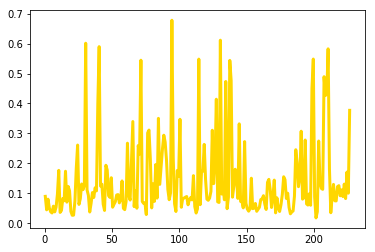

<Figure size 4320x4320 with 0 Axes>

In [36]:
#The following plot show the similarity between two consecutive episodes based on TF-iDF
plt.plot(episode_idx,sim_list, color='gold', linewidth=3)
plt.figure(figsize=(60,60))
plt.show

# A2: 
The graphs from TF and TF-iDF are almost identical. Except, we can see a bit more similarity in the TF-iDF graph. The graph shows that in the drama, each consecutive episode is not strongly connected. The connection only happened a few times in every season.   

### Word2vector

In [42]:
# with open('corpusWord2Vec.txt','w') as f:
#     for i in all_text:
#         f.write(i)
#         f.write('\n')

In [43]:
# word2vec.word2vec('corpusWord2Vec.txt', 'corpusWord2Vec.bin', size=300,verbose=True)

In [37]:
model = word2vec.load('corpusWord2Vec.bin')

In [38]:
print(model.vectors)

[[ 0.08015626  0.08850129 -0.07670335 ... -0.02626957 -0.03316621
   0.0614953 ]
 [-0.04677841  0.05760515  0.10666934 ...  0.10273238 -0.01844324
  -0.1036799 ]
 [-0.01842462  0.02056044  0.07278416 ...  0.09743432 -0.10214183
  -0.13839145]
 ...
 [ 0.02574915  0.01720313  0.05242131 ...  0.04752836 -0.0476199
  -0.01038156]
 [ 0.01706701 -0.01023584  0.00301522 ...  0.02993393 -0.00432843
   0.00459955]
 [-0.00417552 -0.00741058  0.03323089 ...  0.11592586 -0.01388962
  -0.05717817]]


# Q3: What are the 10 most frequent words that connect to each charactor?

### Find similarity with Word2vec

In [39]:
def find_vector(model,word):
    word_idx = np.where(model.vocab == word)
    if word_idx[0].size == 0:
        print("Word not found")
        return 'Error'
    return word_idx[0][0],model.vectors[word_idx[0][0]]

In [40]:
def cosine_similarity(model,word1,word2):
    _,a = find_vector(model,word1)
    _,b = find_vector(model,word2)
    if a!='Error' and b!='Error':
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        return cos_sim
    return None

In [41]:
def find_closest(model,word,num=5):
    closest = []
    word_idx,_ = find_vector(model,word)
    cosine_list = [cosine_similarity(model,word,i) for i in model.vocab]
    print("Closest to "+word.capitalize()+":")
    for i in (np.array(cosine_list).argsort())[-(num+1):]:
        if i!=word_idx:
            closest.append((i,model.vocab[i],cosine_list[i]))
            print((model.vocab[i],cosine_list[i]))
    return closest

In [42]:
name_list = list(collections.Counter(' '.join(all_text).split(' ')).most_common(6)[i][0] for i in range(6))
print(name_list)
name_closest = []
for i in name_list:
    closest_tup = find_closest(model,i,10)
    closest = [closest_tup[i][0] for i in range(10)]
    name01 = np.where(model.vocab == i)
    closest = np.append(closest,name01)
    name_closest.append(closest)
    print('\n')

['ross', 'rachel', 'chandler', 'joey', 'monica', 'phoebe']


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


Closest to Ross:
('benjamin', 0.5915646372479646)
('molly', 0.5993496402342497)
('elizabeth', 0.6151654742747283)
('wha', 0.6233514625457031)
('chloe', 0.6436032479564161)
('paul', 0.6561890988148907)
('charlie', 0.6660062912916361)
('rach', 0.6827308669818317)
('mona', 0.6924213084770522)
('emily', 0.7182993686946262)


Closest to Rachel:
('emma', 0.6066018771816125)
('excitedly', 0.606695215221659)
('mark', 0.6081695844711111)
('ohh', 0.6231061931943763)
('honey', 0.625646508919314)
('sweetie', 0.6449225215728508)
('jill', 0.6498350637482305)
('earring', 0.6715624689337796)
('rach', 0.6769096986867967)
('paul', 0.6994960861877134)


Closest to Chandler:
('kathy', 0.556372856928896)
('joe', 0.5569853399806936)
('suck', 0.5590806432999722)
('porn', 0.5692842475028607)
('janine', 0.5802419823118707)
('pete', 0.5866352563512476)
('janice', 0.6029526579667852)
('bedroom', 0.6232176688591463)
('monica', 0.6412899676768238)
('joey', 0.6660667283460315)


Closest to Joey:
('hiya', 0.57718120

## Exploratory data analysis (EDA)

### Principle component analysis (PCA)

In [44]:
rawWordVec = model.vectors
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

In [45]:
X_reduced

array([[ 0.04995158,  0.37927175],
       [ 0.16112232,  0.6713486 ],
       [ 0.17465924,  0.73350389],
       ...,
       [-0.20375913,  0.19253804],
       [ 0.27215298, -0.17333133],
       [-0.08880101,  0.09523131]])

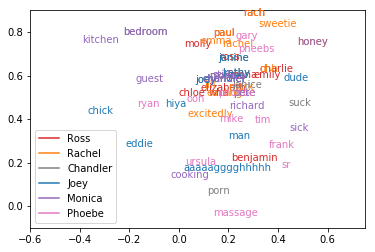

<Figure size 4320x4320 with 0 Axes>

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['C3','C1','C7','C0','C4','C6']
for idx,i in enumerate(name_closest):
    for j in i:
        ax.text(X_reduced[j][0],X_reduced[j][1],model.vocab[j], color=color[idx])
    ax.plot(X_reduced[j][0],X_reduced[j][1], color=color[idx])
    ax.legend([i.capitalize()for i in name_list],loc='lower left')
ax.axis([-0.6,0.75,-0.1,0.9])
plt.figure(figsize=(60,60))
plt.show()

### t-distributed Stochastic Neighbor Embedding (T-SNE)

In [42]:
rawWordVec = model.vectors
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(rawWordVec)

In [43]:
rawWordVec.shape

(7007, 300)

In [47]:
X_tsne

array([[-50.001614,  37.773064],
       [ 35.260212, -44.714058],
       [ 37.378716, -44.7808  ],
       ...,
       [-27.319721, -28.252722],
       [ 29.415253,  -7.250711],
       [ -7.784212,  40.31174 ]], dtype=float32)

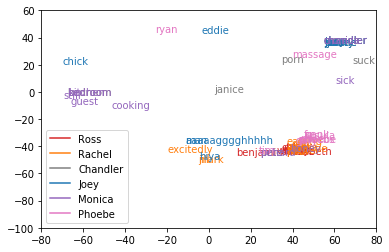

<Figure size 4320x4320 with 0 Axes>

In [45]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
color = ['C3','C1','C7','C0','C4','C6']
for idx,i in enumerate(name_closest):
    for j in i:
        ax1.text(X_tsne[j][0],X_tsne[j][1], model.vocab[j], color=color[idx])
    ax1.plot(X_tsne[j][0],X_tsne[j][1], color=color[idx])
    ax1.legend([i.capitalize()for i in name_list],loc='lower left')
ax1.axis([-80,80,-100,60])
plt.figure(figsize=(60,60))
plt.show()

# A3:
The results seem quite reasonable. 
1. For Ross,  "benjamin" is his son, while "elizabeth", "chloe", "emily" are his ex-girlfriends and of course, "rach" which represents Rachel is strongly connected to Ross.
2. For Rachel, "emma" is the daughter of Rachel and Ross. It is suprising to see that "emma" is not in the top 10 closest words to Ross. In the show, Rachel uses a lot of sweet words such as "hoeny" and "sweetie" which can be proven by the results.
3. For Chandler, obviously, "joey" and "monica" are strongly connected. It is always funny to see "janice," Chandler's ex around him XD. Not suprisingly, the word "porn" shows up here. LOL
4. For Joey, since he is a player, the word "chick" is strongly connected to him. Honestly, I wes expecting to see more girl's names in the results.
5. For Monica, because she is cook, words such as "guest", "kitchen" and "cooking" show up in the results. "richard" is her ex and chandler is her husband.
6. For Phoebe, she is quite of a crazy charactor in this show. From the results, we can see that she is connected to "pheebs" a lot. Just like her charactor's personality, there are a lot of strange words such as "ooh", "ursula" and "sr" in the results.

# Q4: How strong are the connections among charactors?

-Build and plot a relationship matrix

In [106]:
row = len(name_list)
col = row
matrix = np.zeros((row, col))
for i in range(row):
    for j in range(col):
        matrix[i][j] = cosine_similarity(model,name_list[i],name_list[j])
df_name = pd.DataFrame(matrix)
for idx,i in enumerate(name_list):
    df_name.rename(columns ={idx:i.capitalize()}, inplace=True)
    df_name.rename({idx:i.capitalize()}, inplace=True,axis=0)
display(df_name)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


,Ross,Rachel,Chandler,Joey,Monica,Phoebe
Ross,1.000000,0.579538,0.204238,0.405152,0.227973,0.096465
Rachel,0.579538,1.000000,0.342421,0.245073,0.487038,0.467050
Chandler,0.204238,0.342421,1.000000,0.666067,0.641290,0.298718
Joey,0.405152,0.245073,0.666067,1.000000,0.341870,0.122362
Monica,0.227973,0.487038,0.641290,0.341870,1.000000,0.546377
Phoebe,0.096465,0.467050,0.298718,0.122362,0.546377,1.000000


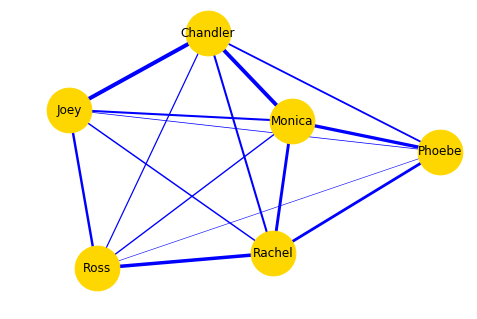

In [320]:
def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier
G = nx.Graph()
for i in name_list:
    G.add_node(i.capitalize())
for i in range(len(name_list)):  
    for j in range(len(name_list)):
        G.add_edge(name_list[i].capitalize(),name_list[j].capitalize(),weight=matrix[i][j]*6)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, with_labels=True,edge_color='b', node_color='gold',node_size = 2000,width = weights)
plt.axis('off')
plt.show()

# A5:
From the result shown above, we can see that the width of the edge between nodes represent the strength of the connectons between charactors. Obviously, "Monica and Chandler", "Joey and Chandler" and "Ross and Rachel" all have a really wide edge which are reasonable when we consider the storyline.  

# Q5: How similar are episodes? Does it follow by seasons?

## Vectorize documents 

## Doc2Vector

In [196]:
# all_text_vec = [i.split() for i in all_text]
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_text_vec)]

In [197]:
# model_doc = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

In [198]:
# model_doc.save("doc2vec.model")

In [218]:
model_doc = Doc2Vec.load("doc2vec.model")

In [241]:
print(model_doc.docvecs.most_similar(0,topn = 10))

[(220, 0.9126065373420715), (20, 0.9082783460617065), (202, 0.9045050740242004), (207, 0.9014537334442139), (5, 0.9011045098304749), (223, 0.8945208787918091), (216, 0.8915578126907349), (6, 0.8912590742111206), (2, 0.8902546167373657), (7, 0.8883451223373413)]


In [323]:
model_d_vec = [model_doc[i] for i in range(228)]

In [246]:
row1 = 228
col1 = row1
matrix_doc = np.zeros((row1, col1))
for i in range(row1):
    for j in range(col1):
        matrix_doc[i][j] = model_doc.docvecs.similarity(i,j)
df_name = pd.DataFrame(matrix_doc)
display(df_name)

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,1.000000,0.797356,0.890255,0.865684,0.820651,0.901105,0.891259,0.888345,0.831707,0.864493,...,0.830935,0.785212,0.912606,0.805013,0.811092,0.894521,0.832348,0.842853,0.871448,0.806564
1,0.797356,1.000000,0.766209,0.769638,0.721161,0.707872,0.771053,0.863010,0.853100,0.693720,...,0.689652,0.801468,0.782899,0.607665,0.786068,0.872022,0.897735,0.872932,0.731577,0.713170
2,0.890255,0.766209,1.000000,0.882560,0.869221,0.905448,0.885067,0.880603,0.895014,0.871736,...,0.874542,0.820565,0.927378,0.823790,0.879573,0.865919,0.793612,0.819510,0.888289,0.822754
3,0.865684,0.769638,0.882560,1.000000,0.851395,0.893502,0.910037,0.876348,0.845959,0.814919,...,0.853767,0.858785,0.886614,0.848867,0.796861,0.827635,0.770252,0.844985,0.884483,0.871312
4,0.820651,0.721161,0.869221,0.851395,1.000000,0.884103,0.844353,0.810815,0.845801,0.839966,...,0.872107,0.844803,0.854410,0.817693,0.733742,0.802943,0.702061,0.793142,0.921629,0.830607
5,0.901105,0.707872,0.905448,0.893502,0.884103,1.000000,0.891776,0.874432,0.816169,0.897801,...,0.913131,0.839969,0.943212,0.917686,0.823911,0.837035,0.777357,0.865184,0.931691,0.844625
6,0.891259,0.771053,0.885067,0.910037,0.844353,0.891776,1.000000,0.895301,0.839577,0.832435,...,0.874432,0.815165,0.907066,0.849929,0.833597,0.846055,0.823145,0.870536,0.879095,0.828588
7,0.888345,0.863010,0.880603,0.876348,0.810815,0.874432,0.895301,1.000000,0.846209,0.867938,...,0.824171,0.868289,0.938082,0.776647,0.866709,0.887952,0.902807,0.903601,0.882923,0.828344
8,0.831707,0.853100,0.895014,0.845959,0.845801,0.816169,0.839577,0.846209,1.000000,0.806769,...,0.843707,0.810725,0.849229,0.749057,0.801317,0.858498,0.814457,0.789804,0.841900,0.763962
9,0.864493,0.693720,0.871736,0.814919,0.839966,0.897801,0.832435,0.867938,0.806769,1.000000,...,0.843480,0.780872,0.920776,0.818426,0.846546,0.805787,0.745238,0.776612,0.873690,0.865113


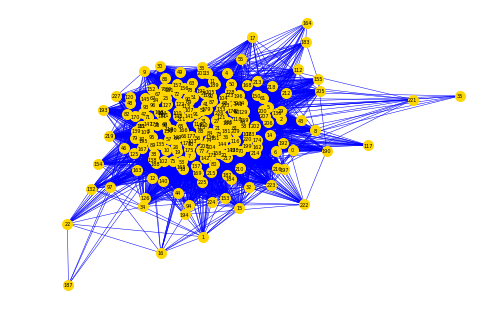

In [280]:
G1 = nx.Graph()
for i in range(228):
    G1.add_node(i)
for i in range(228):  
    for j in range(228):
        if matrix_doc[i][j]>0.85:
            G1.add_edge(i,j)
pos=nx.spring_layout(G1,scale=1000) 
nx.draw(G1, with_labels=True ,edge_color='b', node_color='gold',node_size = 100,width = 0.5, pos=pos,font_size=5)
plt.show()

## Using clustering techniques 

### K means
-since there are 10 seasons in the show, k will be set at 10

In [ ]:
kmeans_fit = cluster.KMeans(n_clusters = 10).fit(model_d_vec)

In [367]:
kmeans_fit.labels_

array([5, 6, 5, 5, 4, 4, 5, 6, 9, 4, 8, 9, 6, 4, 5, 6, 7, 5, 8, 0, 5, 0,
       7, 3, 1, 9, 2, 0, 5, 9, 3, 3, 8, 3, 6, 0, 8, 2, 8, 3, 0, 3, 9, 5,
       8, 3, 0, 1, 3, 3, 4, 5, 0, 6, 1, 1, 8, 0, 3, 3, 1, 5, 1, 1, 0, 0,
       0, 1, 3, 3, 8, 1, 1, 0, 2, 8, 3, 8, 1, 2, 2, 0, 9, 2, 0, 3, 3, 3,
       0, 9, 1, 1, 1, 3, 8, 1, 1, 7, 0, 1, 1, 3, 8, 8, 3, 3, 0, 9, 1, 1,
       3, 1, 9, 3, 1, 1, 2, 3, 1, 1, 1, 2, 3, 1, 3, 6, 8, 1, 1, 3, 9, 3,
       7, 4, 2, 2, 4, 2, 6, 2, 8, 1, 8, 8, 0, 3, 1, 0, 1, 2, 9, 2, 4, 8,
       8, 4, 9, 3, 8, 0, 0, 1, 8, 8, 4, 8, 3, 2, 5, 2, 5, 0, 2, 6, 9, 2,
       4, 0, 1, 1, 1, 0, 8, 4, 2, 0, 2, 7, 2, 1, 0, 4, 5, 4, 6, 6, 3, 8,
       2, 2, 5, 3, 5, 1, 2, 5, 4, 5, 6, 0, 8, 1, 9, 4, 8, 6, 6, 8, 4, 6,
       5, 4, 8, 6, 6, 2, 4, 3], dtype=int32)

#### PCA

In [328]:
X_d = PCA(n_components=2).fit_transform(model_d_vec)

In [341]:
X_d[0,0]

0.45059493313858745

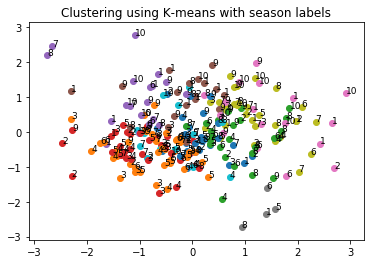

<Figure size 7200x7200 with 0 Axes>

In [366]:
fig = plt.figure()
ax = fig.add_subplot(111)
season = df.Season.tolist()
for i in range(228):
    ax.scatter(X_d[i,0],X_d[i,1],color = 'C'+str(kmeans_fit.labels_[i]))
    ax.text(X_d[i,0],X_d[i,1],season[i], fontsize=9)
plt.title("Clustering using K-means with season labels")
plt.figure(figsize=(100,100))
plt.show()

#### LDA

In [368]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [370]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(model_d_vec,season)
newData = lda.transform(model_d_vec)

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


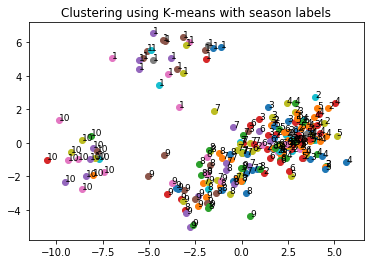

<Figure size 7200x7200 with 0 Axes>

In [375]:
fig = plt.figure()
ax = fig.add_subplot(111)
season = df.Season.tolist()
for i in range(228):
    ax.scatter(newData[i,0],newData[i,1],color = 'C'+str(kmeans_fit.labels_[i]))
    ax.text(newData[i,0],newData[i,1],season[i], fontsize=9)
plt.title("Clustering using K-means with season labels")
plt.figure(figsize=(100,100))
plt.show()

### DBSCAN

In [376]:
from sklearn.cluster import DBSCAN

In [421]:
y_pred = DBSCAN(eps = 0.01,min_samples = 10).fit(model_d_vec)

In [422]:
y_pred.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

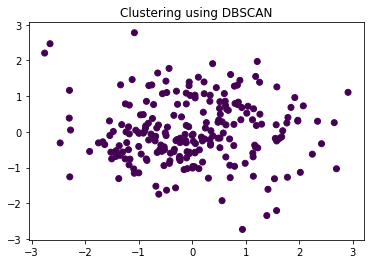

In [426]:
plt.scatter(X_d[:, 0], X_d[:, 1], c=y_pred.labels_)
plt.title("Clustering using DBSCAN")
plt.show()

# A4:
We can find that DBSCAN doesn't work really well in this case. All episodes are considered in the same cluster. On the other hand, K-means seems to do a lot better. However, when I label the season on the plot, it is obvious that K means classify each episode different from their season. This can be shown either by PCA or LDA.

## Organize data person-wise

In [47]:
def get_person_speech(name_list):
    url_dict = get_url_list()
    per_dict = {}
    name_list_c = [(i).capitalize() for i in name_list]
    for i in name_list_c:
        per_dict[i] = []
    for i in list(url_dict.keys()):
        text = get_html(url_dict[i][1])
        html = etree.HTML(text)
        for name in name_list_c:
            path = '//p[descendant::b="'+name+':"]/text()'
            content = html.xpath(path)
            if len(content)==0:
                break
            new_content = []
            for wd in content:
                wd = wd.replace('\n',' ')
                wd = wd.replace('\r',' ')
                wd = wd.strip(' ')
                wd = ' '.join([k for k in wd.split(' ') if k!=''])
                new_content.append(wd)
            per_dict[name].extend(new_content)
    return per_dict

In [48]:
def write_in_json(per_dict):
    with open('Friends_char.json','w') as jsonfile:
        json.dump(per_dict, jsonfile)
    print("Done!")

In [49]:
def read_from_json():
    with open('Friends_char.json','r') as jsonfile:
        per_dict = json.load(jsonfile)
    return per_dict

In [63]:
per_dict = read_from_json()

# Q6: What are the most frequently used words by each charactor?

### Show the words the charactors frequently use

In [69]:
def show_freq_use(name_list_c,top=30):
    stop_words = set(stopwords.words("english"))
    add_words = ['okay','yeah','well','hey','get','look','go','see','know','really','oh','say','want','come','one','gonna','going','would','got','think','little','make','take']
    stop_words = stop_words.union(add_words)
    word_counter = {}
    for j in name_list_c:
        j = j.capitalize()
        all_text = []
        for i in range(len(per_dict[j])):
            text = re.sub('[^a-zA-Z]', ' ', per_dict[j][i])
            text = text.lower()
            text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
            text = text.split()
            lem = WordNetLemmatizer()
            text = [lem.lemmatize(word) for word in text if not word in stop_words] 
            text = " ".join(text)
            if len(text)!=0:
                all_text.append(text)
        word_counter[j] = Counter((' '.join(all_text).split(' '))).most_common(top)
    return word_counter

In [70]:
word_counter = show_freq_use(name_list)

In [71]:
print(word_counter)

{'Ross': [('uh', 572), ('right', 420), ('like', 356), ('rachel', 323), ('mean', 320), ('guy', 303), ('joey', 243), ('chandler', 217), ('monica', 172), ('back', 170), ('yes', 164), ('thing', 162), ('good', 161), ('time', 157), ('sorry', 151), ('umm', 150), ('hi', 147), ('great', 144), ('let', 139), ('huh', 130), ('phoebe', 130), ('start', 129), ('ah', 128), ('something', 126), ('ross', 124), ('tell', 124), ('god', 113), ('love', 112), ('could', 110), ('way', 105)], 'Rachel': [('ross', 515), ('right', 454), ('joey', 396), ('god', 358), ('mean', 352), ('like', 342), ('guy', 297), ('monica', 276), ('uh', 271), ('hi', 253), ('phoebe', 253), ('sorry', 214), ('back', 193), ('thing', 182), ('great', 180), ('chandler', 177), ('tell', 174), ('good', 171), ('yes', 166), ('umm', 164), ('honey', 161), ('wait', 160), ('time', 154), ('thank', 143), ('let', 139), ('love', 135), ('start', 132), ('wow', 125), ('ohh', 125), ('something', 123)], 'Chandler': [('right', 366), ('monica', 310), ('joey', 306),

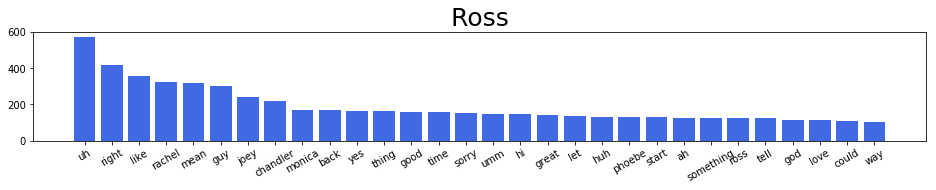

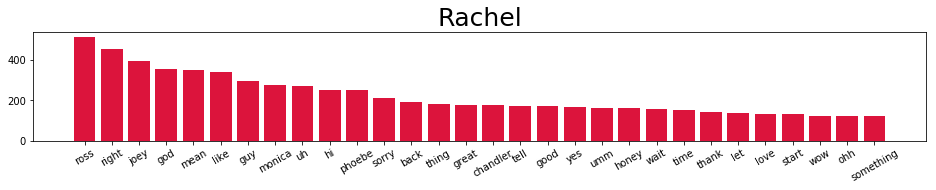

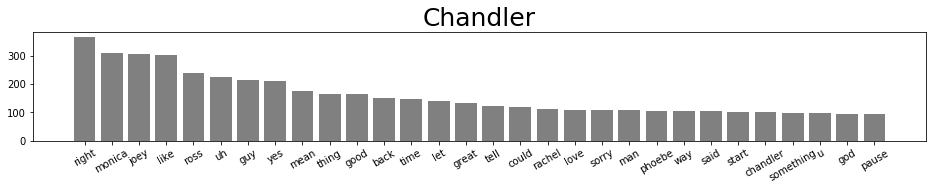

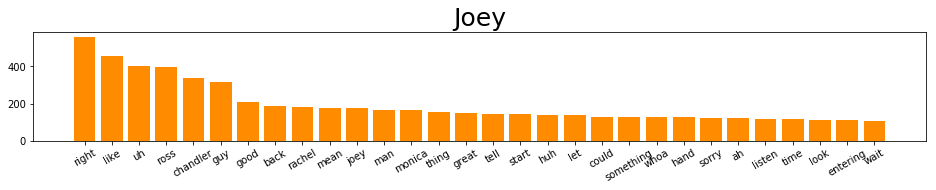

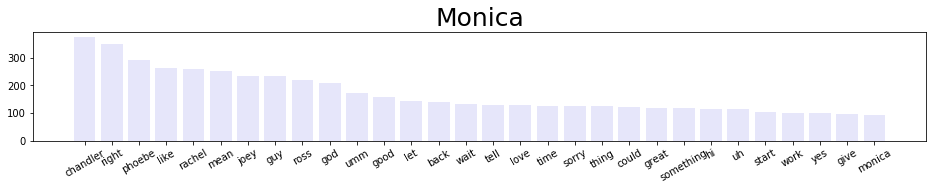

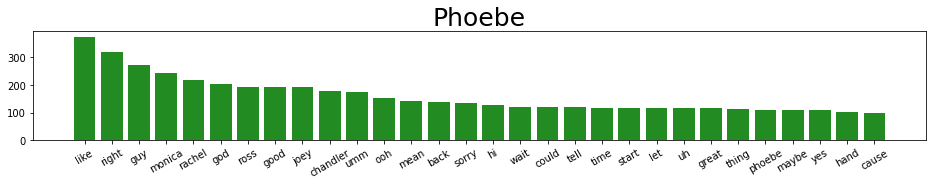

In [72]:
def plot_freq(name,color,word_counter):
    x = [word_counter[name][i][0] for i in range(len(word_counter[name]))]
    y = [word_counter[name][i][1] for i in range(len(word_counter[name]))]
    plt.figure(figsize=(16,2))
    plt.title(name,fontsize=25)
    plt.xticks(rotation=30)
    plt.bar(x,y,color=color)
color = ['royalblue','crimson','gray','darkorange','lavender','forestgreen']
for idx,i in enumerate(name_list):
    plot_freq(i.capitalize(),color[idx],word_counter)
plt.show()

# A6:
I organized the speech for each charactor and performed wordcount on their speech while excluding some stopwords. The result shows that the word they frequently used are all pretty similar and simple. Chandler and Monica speak of each other really often and this is quite reason since they are husband and wife. From the result, we can also see that every charactor all strongly connected to each other. 

# Future work:
Using RNN/LSTM to classify a random sentence into one of the six main charactors